# Display F=GFS6h fcst, O=HRD dropsondes, diffs

### Notebook outline: 

[GFS grids: 6h forecast and analysis](#GFSgrids)

[Read dropsondes](#drops)

[Differences O-F in observation space](#O-F)

[Differences O-A, A-F](#O-A)


In [1]:
import pandas as pd
import numpy as np 
import datetime
import xarray as xr 
import matplotlib.pyplot as plt
# import metpy


<a id='GFSgrids'></a>

# Let's get some model grids to compare to 

[Back to Outline](#Outline)

In [4]:
flight_date = '20210828'
HH = 12                 # flight was at roughly 12Z judging from dropsonde times

# Derived strings 
YYYY = flight_date[0:4]
MM = flight_date[4:6]
DD = flight_date[6:8]

fltime = datetime.datetime(int(YYYY),int(MM),int(DD), HH)

# intialization time is flight time minus lead time. 
# Look at 6h forecast: 
lead = 6 # hours
init = fltime - datetime.timedelta(hours=lead)

foldername = str(init.strftime('%Y%m%d'))
filename = str(init.strftime('%Y%m%d%H'))+'.f'+str(lead).zfill(3)
URL = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds084.1/2021/' \
    + foldername+'/gfs.0p25.'+filename+'.grib2'
 
# Open URL as a dataset: GFS 6F = 6-hour forecast 
GFS6F = xr.open_dataset(URL)
#GFS6F 

<xarray.Dataset>
Dimensions:                                                                   (
                                                                               lat: 721,
                                                                               lon: 1440,
                                                                               time: 1,
                                                                               time_bounds_1: 2,
                                                                               time1: 1,
                                                                               ...
                                                                               height_above_ground4: 1,
                                                                               height_above_ground5: 2,
                                                                               potential_vorticity_surface: 2,
                                                                               sigma: 1,
                                                                               hybrid: 1,
                                                                               hybrid1: 2)
Coordinates: (12/26)
  * lat                                                                       (lat) float32 ...
  * lon                                                                       (lon) float32 ...
    reftime                                                                   datetime64[ns] ...
  * time                                                                      (time) datetime64[ns] ...
  * time1                                                                     (time1) datetime64[ns] ...
  * height_above_ground                                                       (height_above_ground) float32 ...
    ...                                                                        ...
  * height_above_ground4                                                      (height_above_ground4) float32 ...
  * height_above_ground5                                                      (height_above_ground5) float32 ...
  * potential_vorticity_surface                                               (potential_vorticity_surface) float32 ...
  * sigma                                                                     (sigma) float32 ...
  * hybrid                                                                    (hybrid) float32 ...
  * hybrid1                                                                   (hybrid1) float32 ...
Dimensions without coordinates: time_bounds_1,
                                pressure_difference_layer_bounds_1,
                                height_above_ground_layer_bounds_1,
                                height_above_ground_layer1_bounds_1,
                                pressure_difference_layer1_bounds_1,
                                pressure_difference_layer2_bounds_1,
                                sigma_layer_bounds_1,
                                depth_below_surface_layer_bounds_1
Data variables: (12/179)
    LatLon_Projection                                                         int32 ...
    time_bounds                                                               (time, time_bounds_1) datetime64[ns] ...
    pressure_difference_layer_bounds                                          (pressure_difference_layer, pressure_difference_layer_bounds_1) float32 ...
    height_above_ground_layer_bounds                                          (height_above_ground_layer, height_above_ground_layer_bounds_1) float32 ...
    height_above_ground_layer1_bounds                                         (height_above_ground_layer1, height_above_ground_layer1_bounds_1) float32 ...
    pressure_difference_layer1_bounds                                         (pressure_difference_layer1, pressure_difference_layer1_bounds_1) float32 ...
    ...                                                   

<a id='drops'></a>

# Now read all the dropsonde
### to define the lat-lon window 

[Back to Outline](#Outline)

In [ ]:
# Helper function 
def findall(p, s):
    '''Yields all the positions of the pattern p in the string s.'''
    i = s.find(p)
    while i != -1:
        yield i
        i = s.find(p, i+1)

In [6]:
# Request the response to a directory URL 'https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/'
# and find all filenames ending in .frd

import requests
r = requests.get('https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/')
content = r.text

FRDfiles = []
for i in findall('.frd', content):
    FRDfiles.append(content[i-18:i+4])

# remove duplicates
FRDfiles = list(set(FRDfiles))
# Prepend full path
FRDpaths = ['https://seb.noaa.gov/pub/acdata/2021/AVAPS/20210828I1/ASPEN_DATA/' +s for s in FRDfiles]
#FRDpaths

In [ ]:
# Create a list of dataframes, reading the files one by one
# Column names 
cnames = ['IX','t_s','P_mb','T_C','RH','Z_m','WD','WS_ms','U_ms','V_ms','NS','WZ_ms','ZW_m','FP','FT','FH','FW','LAT','LON']

drops = []
for ifile in FRDpaths: 
    print(ifile)
    df = pd.read_csv(ifile, skiprows=21, delim_whitespace=True, names=cnames)
    df.mask((df <= -900), inplace=True)
    drops.append(df)

In [ ]:
alldrops = pd.concat(drops)

#### No reason to get fussy about horizontal interpolation in 1/4 deg GFS, it seems 

In [ ]:
# all the locations 
plt.scatter(alldrops.LON, alldrops.LAT)

In [ ]:
# Plot GFS6F SLP contours and sondes on top 

SLP = GFS6F['Pressure_reduced_to_MSL_msl'].sel( lon=slice(alldrops.LON.min()-1,  \
                                                          alldrops.LON.max()+1), \
                                                lat=slice(alldrops.LAT.min()-1,  \
                                                          alldrops.LAT.max()+1)  )
# Drops on SLP contours
plt.contour(SLP); plt.scatter(alldrops.LON, alldrops.LAT)

--------------------
<a id='O-F'></a>

# Estimate GFS fields at dropsonde points 
### Nearest neighbor in lat-lon, then interpolate in the vertical 

[Back to Outline](#Outline)

In [ ]:
for drop in drops: 
    # Sample GFS6F at the dropsonde LAT, LON from first valid datapoint
    G6column = GFS6F.sel(lat=drop.LAT[0],lon=drop.LON[0],method='nearest')
    plist= G6column.P_mb.values
    Tlist= plist.copy()*0 # right shaped container with NaNs in the right places
    
    # Loop over all non-NAN levels and replace values with interpolated ones
    for i in np.argwhere( np.isfinite(plist) ): 
        Tlist[i] = np.interp(plist[i],G6column['isobaric'].values,\
                                      G6column['Temperature_isobaric'].values)  
    # Add to drop datafrome
    drop['GFS6T'] = pd.Series(Tlist)

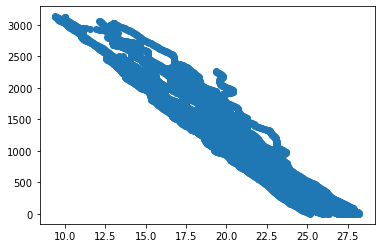

In [133]:
# Scatterplot of all the T profiles against Z
plt.scatter(alldrops.T_C, alldrops.Z_m)
# One model T profile
plt.scatter(drop.GFS6T, drop.Z_m)